# Import Libraries

In [ ]:
from pathlib import Path
import numpy as np
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import datetime
now = datetime.datetime.now

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
import torchvision
from torchvision import transforms
import copy

# Data Loading

In [ ]:
# Load the images
from codes.data_loader import MultiTask_DataSet

# Folder with images
imgs_folder_path = Path("data/images/")
# Folder with masks
msks_folder_path = Path("data/masks/")
# File with labels
labels_path = Path("data/labels.xlsx")

# Resize all images to 256x256 pixels
img_dim = 256
transform_img = transforms.Compose([transforms.Resize((img_dim, img_dim)), transforms.ToTensor()])

# Get the images 
BUS = MultiTask_DataSet(imgs_folder_path, msks_folder_path, transform_img, labels_path)

# Print the number of images in the dataset
num_imgs = len(BUS)
print("Number of images:", num_imgs)

# Print the images shape
print('Images shape:', BUS[0][0].shape)
print('Masks shape:', BUS[0][1].shape)

Number of images: 562
Images shape: torch.Size([3, 256, 256])
Masks shape: torch.Size([1, 256, 256])


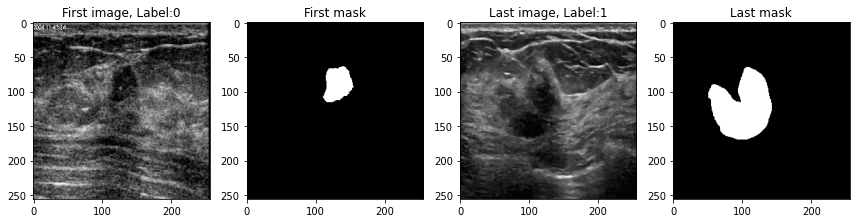

In [ ]:
# Plot the first and last images and masks
plt.figure(figsize = (12,4))
plt.subplot(141)
plt.imshow(np.squeeze(BUS[0][0][0]), cmap = "gray")
plt.title('First image, Label:' + str(BUS[0][2]))
plt.subplot(142)
plt.imshow(np.squeeze(BUS[0][1]), cmap = "gray")
plt.title('First mask')
plt.subplot(143)
plt.imshow(np.squeeze(BUS[-1][0][0]), cmap = "gray")
plt.title('Last image, Label:' + str(BUS[-1][2]))
plt.subplot(144)
plt.imshow(np.squeeze(BUS[-1][1]), cmap = "gray")
plt.title('Last mask')
plt.tight_layout()
plt.show()

In [ ]:
# We will create a separate data loader for the classification branch 
# It will be used for calculating the complexity measures

# Import the data loader
from codes.data_loader import SingleTask_DataSet

# Get the images
BUS_classify = SingleTask_DataSet(imgs_folder_path, transform_img, labels_path)

# Training and Testing for One Epoch

In [ ]:
# Train the model for one epoch on the given set
def train(model, device, train_loader, criterion1, criterion2, optimizer, epoch):
    sum_loss_class, sum_loss_segm, sum_correct, sum_dcs = 0, 0, 0, 0

    # Switch to train mode
    model.train()

    for i, (data, mask, target) in enumerate(train_loader):
        data, mask, target = data.to(device, dtype=torch.float), mask.to(device, dtype=torch.float), target.to(device)

        # Zero all the gradients before the parameters update
        optimizer.zero_grad()
       
        # Compute the output
        output = model(data)

        # Compute the classification loss
        loss_class = criterion1(output[0], target)
        sum_loss_class += len(data) * loss_class.item()

        # Compute the classification accuracy
        pred = output[0].max(1)[1]
        sum_correct += pred.eq(target).sum().item()

        # Compute the segmentation loss (Dice loss)
        loss_segm = criterion2(output[1], mask)
        sum_loss_segm += len(data) * loss_segm.item()

        # Compute the segmentation accuracy (Dice score)
        dc_sc = DiceCoeff(output[1], mask)
        sum_dcs += len(data) * dc_sc.item()

        # Combined classification and segmentation loss
        loss = weight_class*loss_class + weight_segm*loss_segm

        # Compute the gradient and do an SGD step
        loss.backward()
        optimizer.step()

    # Return classification and segmentation loss, and classification and segmentation accuracy
    return sum_loss_class/len(train_loader.dataset), sum_loss_segm/len(train_loader.dataset), sum_correct/len(train_loader.dataset), sum_dcs/len(train_loader.dataset)


# Evaluate the model on the given set
def validate(model, device, val_loader, criterion1, criterion2):
    sum_loss_class, sum_loss_segm, sum_correct, sum_dcs = 0, 0, 0, 0
    
    # Switch to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for i, (data, mask, target) in enumerate(val_loader):
            data, mask, target = data.to(device, dtype=torch.float), mask.to(device, dtype=torch.float), target.to(device)

            # Compute the output
            output = model(data)

            # Compute the classification loss
            loss_class = criterion1(output[0], target)
            sum_loss_class += len(data) * loss_class.item()

            # Compute the classification accuracy
            pred = output[0].max(1)[1]
            sum_correct += pred.eq(target).sum().item()

            # Compute the segmentation loss (Dice loss)
            loss_segm = criterion2(output[1], mask)
            sum_loss_segm += len(data) * loss_segm.item()

            # Compute the segmentation accuracy (Dice score)
            dc_sc = DiceCoeff(output[1], mask)
            sum_dcs += len(data) * dc_sc.item()

    # Return classification and segmentation loss, and classification and segmentation accuracy
    return sum_loss_class/len(val_loader.dataset), sum_loss_segm/len(val_loader.dataset), sum_correct/len(val_loader.dataset), sum_dcs/len(val_loader.dataset)

# Model Training

In [ ]:
# Define training parameters

# Images channels and number of classes
nchannels, nclasses  = 3, 2

# Other parameters
learningrate = 1e-4
batchsize = 2

# Total number of epochs
epochs = 1000
# If verbose=1 print the training and validation loss and accuracy
verbose = 0
# Patience for early stopping (based on non-increasing classification validation accuracy)
n_epochs_stop = 30

# Define the weights coefficients for the classification and segmentation loss
weight_class = 0.2
weight_segm = 0.8

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import the model
from codes.model import Network_MultiTask

# Import the complexity measures
from codes.complexity_measures import get_all_measures

# Import the Dice loss and Dice metric
from codes.metrics import DiceLoss, DiceCoeff

################################################################################
Fold 1
Number of train instances: 360, Number of validation instances: 89, Number of test instances: 113

Early stopping!
Training time: 0:15:02.101966


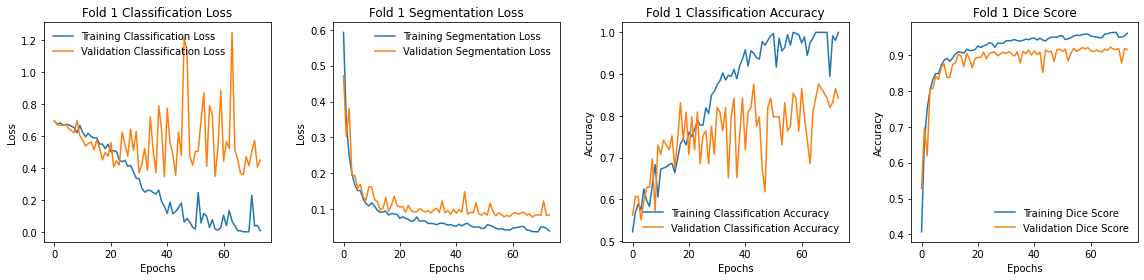


Test dataset performance: Test classification loss: 0.705 	 Test accuracy: 0.770 	 Test dice score: 0.902

Calculate complexity measures!
Time for calculating the measures: 0:05:01.910877

################################################################################
Fold 2
Number of train instances: 360, Number of validation instances: 89, Number of test instances: 113

Early stopping!
Training time: 0:06:07.235868


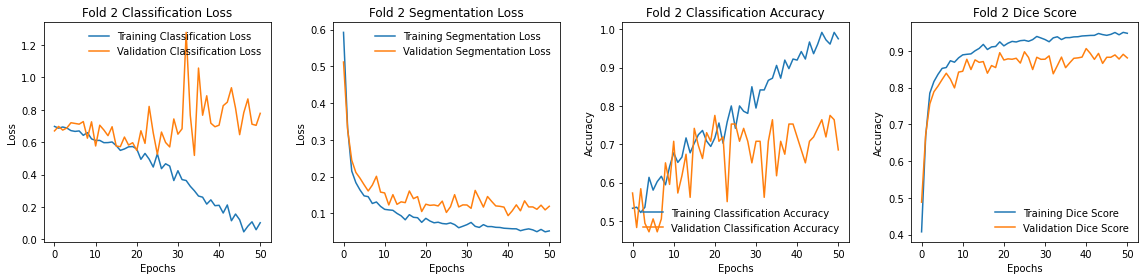


Test dataset performance: Test classification loss: 0.574 	 Test accuracy: 0.814 	 Test dice score: 0.901

Calculate complexity measures!
Time for calculating the measures: 0:03:36.883438

################################################################################
Fold 3
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Early stopping!
Training time: 0:07:11.117670


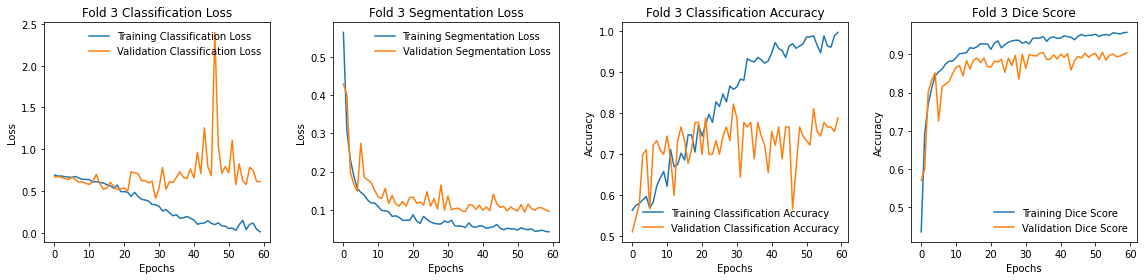


Test dataset performance: Test classification loss: 0.643 	 Test accuracy: 0.839 	 Test dice score: 0.900

Calculate complexity measures!
Time for calculating the measures: 0:03:15.345439

################################################################################
Fold 4
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Early stopping!
Training time: 0:14:06.822951


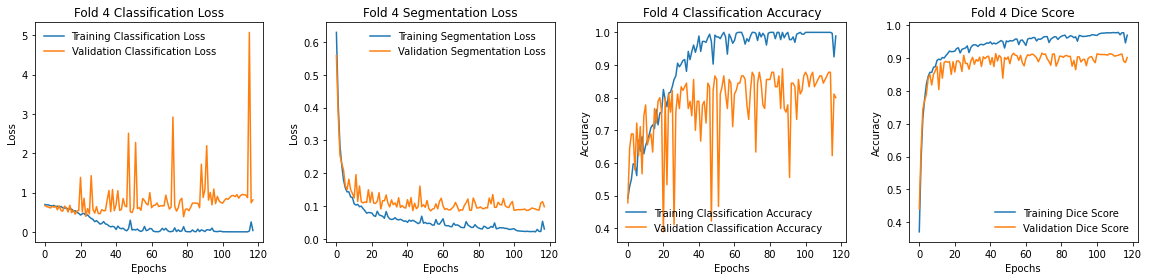


Test dataset performance: Test classification loss: 0.504 	 Test accuracy: 0.839 	 Test dice score: 0.902

Calculate complexity measures!
Time for calculating the measures: 0:03:37.270148

################################################################################
Fold 5
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Early stopping!
Training time: 0:07:18.162920


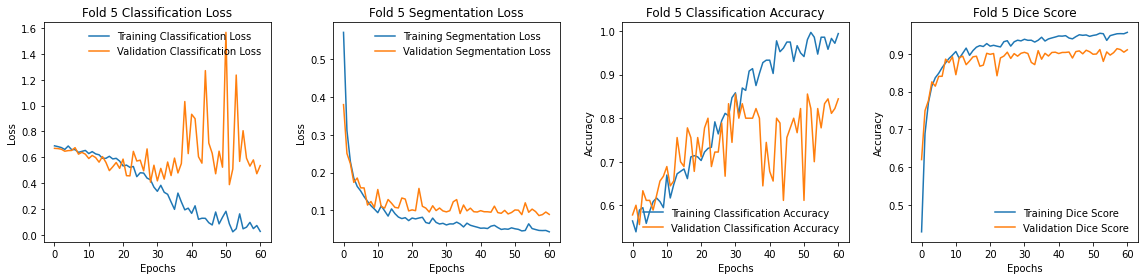


Test dataset performance: Test classification loss: 0.537 	 Test accuracy: 0.795 	 Test dice score: 0.909

Calculate complexity measures!
Time for calculating the measures: 0:04:39.528097



In [ ]:
# Training with 5-fold cross-validation
n_folds = 5
kfold = KFold(n_folds, shuffle=True)

# Tensors for classification and segmentation accuracy and loss
train_acc = torch.zeros([n_folds], dtype=torch.float64, device=device)
train_classloss = torch.zeros([n_folds], dtype=torch.float64, device=device)
train_dcs = torch.zeros([n_folds], dtype=torch.float64, device=device)
train_segmloss = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_acc = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_classloss = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_dcs = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_segmloss = torch.zeros([n_folds], dtype=torch.float64, device=device)

for k, [train_ix, test_ix] in enumerate(kfold.split(BUS), 1):
    print('#'*80)
    print(f'Fold {k}')

    # Prepare the data for the folds
    train_fold = Subset(BUS, train_ix)
    test_fold = Subset(BUS, test_ix)

    # Number of validation instances
    n_val = int(0.2*len(train_fold))

    # Split into train and validation sets
    train_dataset, val_dataset = torch.utils.data.random_split(train_fold, [len(train_fold)-n_val, n_val])
    print(f'Number of train instances: {len(train_dataset)}, Number of validation instances: {len(val_dataset)}, Number of test instances: {len(test_ix)}\n')

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
    test_loader = DataLoader(test_fold, batch_size=batchsize, shuffle=False)

    # Keep track of cross-entropy losses and errors
    train_classlosses = []
    train_segmlosses = []
    train_accuracy = []
    train_dcscore = []
    valid_classlosses = []
    valid_segmlosses = []
    valid_accuracy = []
    valid_dcscore = []

    # Create an instance of the model
    model = Network_MultiTask(nchannels, nclasses)
    model = model.to(device)

    # Create a copy of the initial model, will be used for calculating complexity measures
    init_model = copy.deepcopy(model)

    # Define classification and segmentation loss functions (criterions 1 and 2) and optimizer
    criterion1 = nn.CrossEntropyLoss().to(device)
    criterion2 = DiceLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learningrate)

    # Initialize the maximim validation accuracy
    max_val_acc = 0

    # Record the time (to report the training time)
    t = now()

    # Training the model
    for epoch in range(0, epochs):

        # Train for one epoch
        tr_classloss, tr_segmloss, tr_acc, tr_dcs = train(model, device, train_loader, criterion1, criterion2, optimizer, epoch)

        # Evaluate after each epoch
        val_classloss, val_segmloss, val_acc, val_dcs = validate(model, device, val_loader, criterion1, criterion2)

        train_classlosses.append(tr_classloss)
        train_segmlosses.append(tr_segmloss)
        train_accuracy.append(tr_acc)
        train_dcscore.append(tr_dcs)
        valid_classlosses.append(val_classloss)
        valid_segmlosses.append(val_segmloss)
        valid_accuracy.append(val_acc)
        valid_dcscore.append(val_dcs)

        # Display after each epoch
        if verbose==1:
            print(f'Epoch: {epoch + 1}/{epochs}\t Training classification loss: {tr_classloss:.3f}\t',
                  f'Training segmentation loss: {tr_segmloss:.3f}\t Training class accuracy: {tr_acc:.3f}\t',
                  f'Validation class accuracy: {val_acc:.3f}')

        # Check early stopping condition
        if val_acc > max_val_acc:
            epochs_no_improve = 0
            max_val_acc = val_acc
        else:
            epochs_no_improve += 1
      
        if epoch > n_epochs_stop and epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue
    
    print('Training time: %s' % (now() - t))
    
    plt.figure(figsize = (16,4))
    plt.subplot(141)
    plt.plot(train_classlosses, label='Training Classification Loss')
    plt.plot(valid_classlosses, label='Validation Classification Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f'Fold {k} Classification Loss')
    plt.legend(frameon=False)
    plt.subplot(142)
    plt.plot(train_segmlosses, label='Training Segmentation Loss')
    plt.plot(valid_segmlosses, label='Validation Segmentation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f'Fold {k} Segmentation Loss')
    plt.legend(frameon=False)
    plt.subplot(143)
    plt.plot(train_accuracy, label='Training Classification Accuracy')
    plt.plot(valid_accuracy, label='Validation Classification Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f'Fold {k} Classification Accuracy')
    plt.legend(frameon=False)
    plt.subplot(144)
    plt.plot(train_dcscore, label='Training Dice Score')
    plt.plot(valid_dcscore, label='Validation Dice Score')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f'Fold {k} Dice Score')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    train_acc[k-1] = train_accuracy[-1]
    train_classloss[k-1] = train_classlosses[-1]
    train_dcs[k-1] = train_dcscore[-1]
    train_segmloss[k-1] = train_segmlosses[-1]

    # Calculate the classification and segmentation loss and accuracy of the learned model
    test_classloss[k-1], test_segmloss[k-1], test_acc[k-1], test_dcs[k-1] = validate(model, device, test_loader, criterion1, criterion2)
    print(f'\nTest dataset performance: Test classification loss: {test_classloss[k-1]:.3f} \t Test accuracy: {test_acc[k-1]:.3f} \t Test dice score: {test_dcs[k-1]:.3f}')
    
    #########################################################################
    # Calculate complexity measures
    print("\nCalculate complexity measures!")

    # Complexity measures will be calculated only for the classification branch
    # First, we need to extract the weights of the classification branch from the multitask model

    # Import the model for the classification branch
    from codes.model import Network_SingleTask

    # Dictionary of weights
    model_classify = Network_SingleTask(nchannels, nclasses)
    model_classify_dict = model_classify.state_dict()
    # Dictionary of the pretrained multitask model
    model_dict = model.state_dict()
    # 1. Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in model_dict.items() if k in model_classify_dict}
    # 2. Overwrite entries in the existing state dict
    model_classify_dict.update(pretrained_dict)
    # 3. Load the new state dict for the classification branch
    model_classify.load_state_dict(model_classify_dict)
    # Model to device
    model_classify = model_classify.to(device)

    # Repeat the same procedure for the initial model
    # Dictionary of weights
    init_model_dict = init_model.state_dict()
    init_model_classify = Network_SingleTask(nchannels, nclasses)
    init_model_classify_dict = init_model_classify.state_dict()
    # 1. Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in init_model_dict.items() if k in init_model_classify_dict}
    # 2. Overwrite entries in the existing state dict
    init_model_classify_dict.update(pretrained_dict)
    # 3. Load the new state dict
    init_model_classify.load_state_dict(init_model_classify_dict)
    # Model to device
    init_model_classify = init_model_classify.to(device)

    # We need to create a data loader for the classification branch
    # Training dataset
    train_fold_classify = Subset(BUS_classify, train_ix)
    # Data loader
    train_loader_classify = DataLoader(train_fold_classify, batch_size=batchsize, shuffle=False)

    train_acc_classify = train_acc[k-1].detach().cpu().numpy()
    
    # Record the time
    t = now()

    globals()['train_measures_'+str(k-1)] = {};
    globals()['train_measures_'+str(k-1)] = get_all_measures(model_classify, init_model_classify, train_loader_classify, train_acc_classify, seed=0)

    print('Time for calculating the measures: %s\n' % (now() - t))

In [ ]:
folds_list = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Display the train and test errors for all 5 folds in a pandas DataFrame
all_errors = pandas.DataFrame({'Train Classification Error': 1-train_acc.detach().cpu().numpy(), 'Train Segmentation Dice Score': train_dcs.detach().cpu().numpy(),
                        'Test Classification Error': 1-test_acc.detach().cpu().numpy(), 'Test Segmentation Dice Score': test_dcs.detach().cpu().numpy()}, index = folds_list) 
all_errors

,Train Classification Error,Train Segmentation Dice Score,Test Classification Error,Test Segmentation Dice Score
Fold 1,0.000000,0.961112,0.230088,0.901728
Fold 2,0.025000,0.947610,0.185841,0.901275
Fold 3,0.002778,0.957858,0.160714,0.899963
Fold 4,0.011111,0.970287,0.160714,0.901782
Fold 5,0.005556,0.956510,0.205357,0.909027


In [ ]:
# Display the calculated complexity measures for all 5 folds in a pandas DataFrame
all_measures = pandas.DataFrame([train_measures_0, train_measures_1, train_measures_2, train_measures_3, train_measures_4], index = folds_list)
all_measures

,ComplexityType.L2,ComplexityType.L2_DIST,ComplexityType.PARAMS,ComplexityType.INVERSE_MARGIN,ComplexityType.LOG_PROD_OF_SPEC,ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN,ComplexityType.LOG_SPEC_INIT_MAIN,ComplexityType.FRO_OVER_SPEC,ComplexityType.LOG_SPEC_ORIG_MAIN,ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN,ComplexityType.LOG_SUM_OF_SPEC,ComplexityType.LOG_PROD_OF_FRO,ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN,ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN,ComplexityType.LOG_SUM_OF_FRO,ComplexityType.FRO_DIST,ComplexityType.DIST_SPEC_INIT,ComplexityType.PARAM_NORM,ComplexityType.PATH_NORM,ComplexityType.PATH_NORM_OVER_MARGIN,ComplexityType.PACBAYES_INIT,ComplexityType.PACBAYES_ORIG,ComplexityType.PACBAYES_FLATNESS,ComplexityType.PACBAYES_MAG_INIT,ComplexityType.PACBAYES_MAG_ORIG,ComplexityType.PACBAYES_MAG_FLATNESS
Fold 1,0.512806,0.483417,104.036656,0.017702,32.248002,31.267450,33.572602,0.745214,34.026876,0.006451,0.049084,48.826524,47.845971,0.727257,0.769890,4.951845,2.315313,5.572237,0.017082,0.006408,21.128835,23.775733,0.402713,125.051998,127.579771,0.088834
Fold 2,0.460288,0.418892,104.036656,0.327031,31.482644,33.418454,35.744863,0.773057,36.214563,0.099973,0.015808,48.651246,50.587056,0.846434,0.762269,3.718146,1.723251,4.489342,0.019011,0.131737,23.797010,28.732510,0.604069,128.429736,132.338943,0.188772
Fold 3,0.471858,0.432879,103.920996,0.024441,32.003516,31.346640,33.633998,0.757546,34.123591,0.008830,0.037390,49.036929,48.380053,0.749414,0.777973,3.975028,1.735137,4.723118,0.020258,0.010503,18.172677,21.592340,0.430998,121.585274,125.354192,0.094281
Fold 4,0.497074,0.465661,103.920996,0.024509,32.298617,31.644534,34.040480,0.706629,34.351908,0.021782,0.050221,48.425937,47.771853,0.722970,0.751409,4.599874,1.887774,5.241418,0.022606,0.011753,19.627163,22.364288,0.402265,122.604549,125.445747,0.094281
Fold 5,0.484545,0.449447,103.920996,0.089848,31.990588,32.635573,34.930484,0.746728,35.398143,0.064871,0.036828,48.733748,49.378733,0.792835,0.764792,4.285114,2.019412,4.980524,0.020045,0.038206,24.932396,28.978306,0.548543,128.591273,131.709542,0.150849


# Calculate Kendall's Correlation Coefficients 

Note: the number of used models is low; it is required to run many more models to obtain reliable correlations

In [ ]:
test_error = all_errors['Test Classification Error']
train_error = all_errors['Train Classification Error']

In [ ]:
import scipy.stats as stats

# Kendall's rank-correlation coefficients
print('Correlations Between Compexity Measures and Generalization Gap (Test Error-Train Error):\n')
for i in range(all_measures.shape[1]):
    tau_gen_gap, p_value = stats.kendalltau(test_error-train_error, all_measures.iloc[:,i])
    print(all_measures.columns[i], '\t\t', tau_gen_gap)

Correlations Between Compexity Measures and Generalization Gap (Test Error-Train Error):

ComplexityType.L2 		 0.19999999999999998
ComplexityType.L2_DIST 		 0.19999999999999998
ComplexityType.PARAMS 		 0.5163977794943223
ComplexityType.INVERSE_MARGIN 		 -0.19999999999999998
ComplexityType.LOG_PROD_OF_SPEC 		 -0.19999999999999998
ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN 		 -0.19999999999999998
ComplexityType.LOG_SPEC_INIT_MAIN 		 -0.19999999999999998
ComplexityType.FRO_OVER_SPEC 		 0.0
ComplexityType.LOG_SPEC_ORIG_MAIN 		 -0.19999999999999998
ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN 		 -0.19999999999999998
ComplexityType.LOG_SUM_OF_SPEC 		 -0.19999999999999998
ComplexityType.LOG_PROD_OF_FRO 		 0.39999999999999997
ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN 		 0.19999999999999998
ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN 		 0.19999999999999998
ComplexityType.LOG_SUM_OF_FRO 		 0.39999999999999997
ComplexityType.FRO_DIST 		 0.19999999999999998
ComplexityType.DIST_SPEC_INIT 		 0.3999999

In [ ]:
# Kendall's rank-correlation coefficients
print('Correlations Between Compexity Measures and Test Error:\n')
for i in range(all_measures.shape[1]):
    tau_test_error, p_value = stats.kendalltau(test_error, all_measures.iloc[:,i])
    print(all_measures.columns[i], '\t\t', tau_test_error)

Correlations Between Compexity Measures and Test Error:

ComplexityType.L2 		 0.31622776601683794
ComplexityType.L2_DIST 		 0.31622776601683794
ComplexityType.PARAMS 		 0.5443310539518174
ComplexityType.INVERSE_MARGIN 		 -0.10540925533894596
ComplexityType.LOG_PROD_OF_SPEC 		 -0.10540925533894596
ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN 		 -0.10540925533894596
ComplexityType.LOG_SPEC_INIT_MAIN 		 -0.10540925533894596
ComplexityType.FRO_OVER_SPEC 		 -0.10540925533894596
ComplexityType.LOG_SPEC_ORIG_MAIN 		 -0.10540925533894596
ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN 		 -0.10540925533894596
ComplexityType.LOG_SUM_OF_SPEC 		 -0.10540925533894596
ComplexityType.LOG_PROD_OF_FRO 		 0.31622776601683794
ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN 		 0.10540925533894596
ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN 		 0.10540925533894596
ComplexityType.LOG_SUM_OF_FRO 		 0.31622776601683794
ComplexityType.FRO_DIST 		 0.31622776601683794
ComplexityType.DIST_SPEC_INIT 		 0.5270462766947299
Comple

# Print the Model

In [ ]:
# Display the layers
print(model)

Network_MultiTask(
  (Conv_Block_1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv_Block_2): DownConv(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, e

In [ ]:
# Summary of the feature maps at each layer
summary(model, input_size=(nchannels, img_dim, img_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
        DoubleConv-7         [-1, 32, 256, 256]               0
         MaxPool2d-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1